# ML Final Project


### Shruti Kotha, Mia Tey, Jeni Pham, and Shruti Patel

## Table of Contents 

1. [Final Project Objective](#Objective)
2. [Part 1A. Data Preparation - Data Exploration and Data Cleaning for Modeling](#Part-1)
3. [Part 1B. Data Preparation - Data Exploration Analysis](#Part-2)
4. [Part 1C. Feature Engineering: Encoding](#Part-3-Feature-Engineering-for-Models)
5. [Part 2. Data Modeling](#Part-4-Data-Modeling)
6. [Outcome and Results](#Outcome)

### Added necessary imports

In [73]:
#add imports
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
import warnings

## Final Project Objective: <a id='Objective'></a>

**Goal:** The primary objective of this project is to assist in predicting the outcomes of new intakes at the Austin Animal Center, with a specific focus on dogs. By leveraging various features such as age, breed, color, animal type, sex upon outcome, season of outcome, etc. our aim is to develop a predictive model that can categorize outcomes into classes like Foster, Adoption, Transfer, or Euthanize.

**Why We Want to Do This:**

1. **Optimizing Resource Allocation:** Predicting the outcomes of new intakes enables the Austin Animal Center to allocate resources more efficiently. For instance, if we can accurately predict that a certain dog is likely to be adopted quickly, the center can prioritize resources, such as marketing efforts or special adoption events, for other animals that may need more assistance in finding suitable homes.

2. **Enhancing Animal Welfare:** We can ensure that appropriate care and attention are given to animals that might face challenges in finding suitable homes, increasing the chances of positive outcomes for all animals.

3. **Reducing Euthanasia Rates:** If we can identify factors that contribute to positive outcomes such as adoption or fostering, the center can implement targeted strategies to reduce euthanasia rates. We can determine which dogs are more likely to be euthanized and add additional staff to focus on their well being to avoid euthnasia.

**Problems That Can Be Solved by Predicting Outcomes:**

1. **Overcrowding:** Animal shelters often face challenges related to overcrowding. By predicting outcomes, shelters can implement proactive measures to address potential overcrowding issues, such as encouraging adoptions or transfers to partner organizations.

2. **Resource Management:** Limited resources, including staff time, funding, and space, are common issues in animal shelters. Predicting outcomes allows for better resource management, directing efforts toward animals that require more attention and increasing the efficiency of daily operations.

3. **Animal Well-being:** Ensuring the well-being of animals is a fundamental goal for any animal center. We can help create care plans based on the expected duration of stay and the likelihood of adoption, thereby improving the overall quality of life for the animals.

In summary, by developing this prediction model, the Austin Animal Center can enhance its operational efficiency, improve the lives of the animals in its care, and work towards the broader goal of creating a more sustainable and compassionate approach to animal welfare.

## Our dataset: 
Our chosen dataset gives information about the Animal Center Outcomes from Oct, 1st 2013 to present. The dataset has 156,406 records and 12 features. Our dataset can be found here: Data.gov: Austin Animal Center Outcomes https://www.google.com/url?q=https://catalog.data.gov/dataset/austin-animal-center-outcomes&sa=D&source=docs&ust=1700010068639490&usg=AOvVaw1x_TF7vgepvCGaLXp_ri01



**Feature descriptions:**
* **Animal ID**: Unique ID given to each animal upon intake
* **Name**: Name given to each animal upon intake
* **DateTime**: Date (MM/DD/YEAR) and Time of the outcome of the animal
* **MonthYear**: Month and Year of of the outcome of the animal
* **Date of Birth**: Date (MM/DD/YEAR) the animal was born
* **Outcome Type**: How the animal left the shelter. This is the label we are trying to predict.
* **Outcome Subtype**: Additional information on how the animal left the shelter
* **Animal Type**: Type the animal is. (Cat, Dog, Other, etc.)
* **Sex upon Outcome**: Neutered Male, Neutered Female, Intact Male, Intact Female, Unknown
* **Age upon Outcome**: Age of the animal when they left in years
* **Breed**: Breed of the animal
* **Color**: Color of the animal





## Part 1A. Data Preparation - Data Exploration and Data Cleaning for Modeling <a id='Part-1'></a>
For this part of the assignment, we read in our data and will perform various data prep techniques like data cleaning and feature engineering to prepare our data for modeling.


In [74]:
data = pd.read_csv('animaloutcomes.csv', skipinitialspace = True)
data.head()

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A674754,NaN,03/18/2014 11:47:00 AM,Mar 2014,03/12/2014,Transfer,Partner,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156406 entries, 0 to 156405
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Animal ID         156406 non-null  object
 1   Name              111424 non-null  object
 2   DateTime          156406 non-null  object
 3   MonthYear         156406 non-null  object
 4   Date of Birth     156406 non-null  object
 5   Outcome Type      156376 non-null  object
 6   Outcome Subtype   72101 non-null   object
 7   Animal Type       156406 non-null  object
 8   Sex upon Outcome  156404 non-null  object
 9   Age upon Outcome  156399 non-null  object
 10  Breed             156406 non-null  object
 11  Color             156406 non-null  object
dtypes: object(12)
memory usage: 14.3+ MB


We now want to drop unnecessary columns, as we will only keep features relevant to the outcome type for modeling. We drop outcome subtype because this column is very similar to our label (Outcome). We wouldn't want our models to be exposed to this information before making their predictions to prevent **data leakage**. In a real life context, outcome subtype would only be known after the animal outcome has occured/is known. Thus, we want our models to make predictions without knowing this feature.

In [76]:
print("Number of empty records for outcome subtype:", data['Outcome Subtype'].isna().sum())
print("\nOutcome subtype frequency distribution")
outcome_counts = data['Outcome Subtype'].value_counts()
print(outcome_counts)

Number of empty records for outcome subtype: 84305

Outcome subtype frequency distribution
Outcome Subtype
Partner                37307
Foster                 15332
Rabies Risk             4472
Suffering               3816
Snr                     3459
SCRP                    3211
Out State                931
In Kennel                773
Aggressive               597
Offsite                  495
In Foster                370
Medical                  340
At Vet                   322
Field                    183
Behavior                 167
Enroute                  102
Court/Investigation       62
Underage                  37
In Surgery                32
Customer S                18
Possible Theft            16
Emergency                 15
Prc                       13
Barn                      12
In State                  12
Emer                       7
Name: count, dtype: int64


We will also drop the names feature because there are many unique names for pets, and names are difficult to categorize for engineering. For now, we will focus on the other features for the context of this project. Additionally, many of the pets also have their IDs representing their names, so there wouldn't necessarily be a recognizable correlation for names to relate to outcome type.

In [77]:
print("Number of empty records for names:", data['Name'].isna().sum())
print("\nName frequency distribution")
outcome_counts = data['Name'].value_counts()
print(outcome_counts)


Number of empty records for names: 44982

Name frequency distribution
Name
Max            673
Luna           662
Bella          632
Rocky          455
Daisy          442
              ... 
Almonzo          1
Volare           1
Bunny Holly      1
A863295          1
A854626          1
Name: count, Length: 27312, dtype: int64


We drop the above mentioned features along with date/time because for our date representation in modeling we will end up using the MonthYear column instead. We also drop date of birth because we have a separate age column to represent the age of the pet. Animal ID is also dropped because it won't be useful for our modeling.

In [78]:
data.drop(columns=['Outcome Subtype', 'Name', 'DateTime', 'Date of Birth', 'Animal ID'], inplace=True)
# print the head to ensure only columns important to us are in the dataset
data.head()

,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Gray
3,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby


Let's check to see if we have any null data values in the columns we will be using to model our data. 

In [79]:
data.isnull().sum()

MonthYear            0
Outcome Type        30
Animal Type          0
Sex upon Outcome     2
Age upon Outcome     7
Breed                0
Color                0
dtype: int64

There are a few entries in Outcome Type, Sex upon Outcome, and Age upon Outcome that are null which we will remove. We will do one additional check to make sure we don't have any Nulls in our dataset.

In [80]:
print("Length before droping: ", len(data['Outcome Type']))
data = data.dropna(subset=['Outcome Type', 'Sex upon Outcome', 'Age upon Outcome' ])
print("Length after drop Outcome Type: ", len(data['Outcome Type']))
data.isnull().sum()

Length before droping:  156406
Length after drop Outcome Type:  156368


MonthYear           0
Outcome Type        0
Animal Type         0
Sex upon Outcome    0
Age upon Outcome    0
Breed               0
Color               0
dtype: int64

## Part 1B. Data Preparation - Data Exploration Analysis<a id='Part-2'></a>


We will now further explore the data to gain insights and better understand its characteristics. In this section, we will be graphing data distributions as part of data exploration and will be looking for any imbalances, outliers, or anything that could potentially skew the results of our data.
Using this information, we'll adjust the data before modeling. 

Here we have an overview description of some of our data. It looks like some categorical features (MonthYear, Breed, Color) have a high amount of unique values, which we will address later on. 

In [81]:
data.describe()

,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
count,156368,156368,156368,156368,156368,156368,156368
unique,121,10,5,5,54,2881,634
top,Jun 2019,Adoption,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,2244,73675,86520,54766,26197,33588,16303


Let's start with looking at the distribution of the colors feature. Here's the data for it.

In [82]:
print("\nColor frequency distribution")
outcome_counts = data['Color'].value_counts()
print(outcome_counts)


Color frequency distribution
Color
Black/White             16303
Black                   13052
Brown Tabby              9263
Brown                    6497
White                    5488
                        ...  
Gray Tabby/Orange           1
Brown Tabby/Blue            1
Blue Tabby/Buff             1
Chocolate/Gold              1
Yellow Brindle/Brown        1
Name: count, Length: 634, dtype: int64


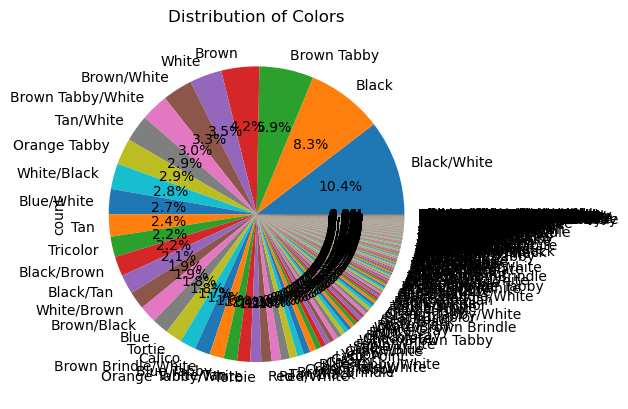

In [83]:
color_counts = data['Color'].value_counts()
color_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Colors')
plt.show()

There are 635 different colors. As the chart shows, this can be challenging to categorize and represent in our modeling accurately. Additionally, there are animal colors of low frequencies that can influence the prediction our models make in an inaccurate way. Also many duplicates are present (ex: Black/Brown, Brown/Black) Let's clean up this color column and simplify the categories by removing duplicates and prioritizing high frequency colors in animals. 

First, there are entries such as 'black/white' and 'white/black' let's combine these into one label.
Second, there are a lot of unique combinations of two colors. For these records whose combination of color makes up <5% of all colors, add these into one column called 'Multicolor' and jointly categorize it with the 'Tricolor' attribute.

In [84]:
color_count_before = len(data['Color'].value_counts())
print("Number of unique colors before: ", color_count_before)

# Combine categories such as 'black/white' and 'white/black'
def join_same_color(color):
    color_components = color.split('/')
    color_components.sort()
    return '/'.join(color_components)
data['Color'] = data['Color'].apply(join_same_color)

# Create Multicolor category 
color_counts = data['Color'].value_counts()
color_percent = color_counts / color_counts.sum() * 100
less_than_5_percent = color_percent[color_percent < 1].index
data['Color'] = data['Color'].apply(lambda x: 'Multicolor' if x in less_than_5_percent or x == 'Tricolor' else x)
print("Number of unique colors after: ", len(data['Color'].value_counts()))


Number of unique colors before:  634
Number of unique colors after:  23


We were able to successfully reduce the excessive number of unique colors to 23 in the dataset and make this data column a lot easier for the models to parse through to make predictions. Here is the plot for the new distribution of colors. 

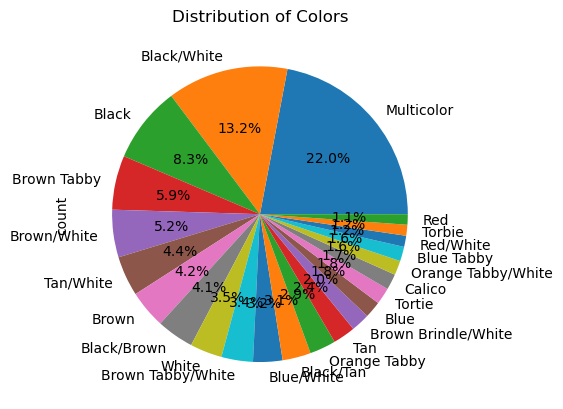

In [85]:
color_counts = data['Color'].value_counts()
color_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Colors')
plt.show()

Let's look at the distribution of the adoption month/year column now.

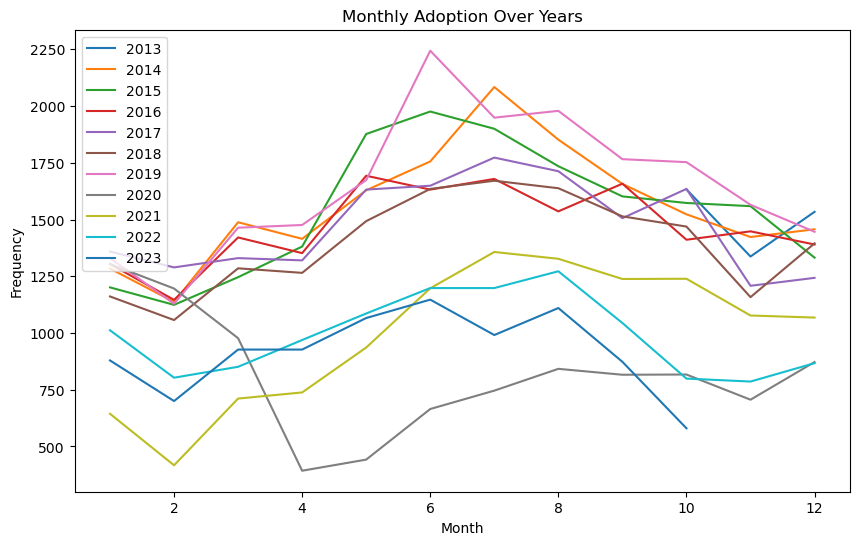

In [86]:
data['Month'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.month
data['Year'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.year
unique_years = sorted(data['Year'].unique())

monthly_frequency = data.groupby(['Year', 'Month']).size().unstack().T

# Plot the data
plt.figure(figsize=(10, 6))

for year in unique_years:
    plt.plot(monthly_frequency.index, monthly_frequency[year], label=str(year))

plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Monthly Adoption Over Years')
plt.legend()
plt.show()


The data is recorded from over a decade. Many months/years are represented within the dataset which can make it difficult for models use this info to make quality predictions. Additionally, past years aren't neccessarily helpful for us to track as a feature because they don't offer any additional insight that we can apply to future pet adoption considerations. Thus, we will focus on using months. 

We can still further categorize months into seasons as each month's scope can still be too broad to determine animal outcomes accurately. This will simplify the month/year column for modeling. Here we create a new column for seasons and drop the Year/Month columns we temporarily made.

In [87]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'
    
data['Month'] = pd.to_datetime(data['MonthYear'], format='%b %Y').dt.month
data['Season'] = data['Month'].apply(get_season)

data.head()

,MonthYear,Outcome Type,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color,Month,Year,Season
0,May 2019,Rto-Adopt,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White,5,2019,Spring
1,Jul 2018,Adoption,Dog,Neutered Male,1 year,Chihuahua Shorthair Mix,Brown/White,7,2018,Summer
2,Aug 2020,Euthanasia,Other,Unknown,1 year,Raccoon,Multicolor,8,2020,Summer
3,Feb 2016,Adoption,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Multicolor,2,2016,Winter
4,Mar 2014,Transfer,Cat,Intact Male,6 days,Domestic Shorthair Mix,Orange Tabby,3,2014,Spring


Let's view the distribution of pets within each month

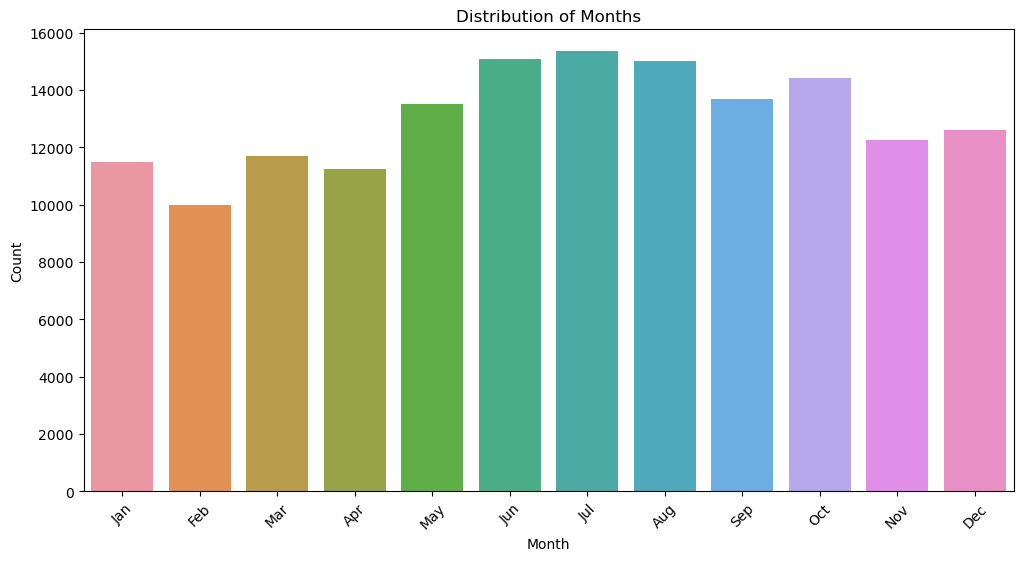

In [88]:
month_data = data['MonthYear']
df = pd.DataFrame(month_data)
pattern = r'([a-zA-Z]{3}) \d{4}'
df['MonthYear'] = df['MonthYear'].str.extract(pattern)
# print(df)
data.head()
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

month_counts = df['MonthYear'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index, y=month_counts.values, order=month_order)
plt.title('Distribution of Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


There isn't an alarmingly outlier so we can keep the data as is and combine months into seasons.

In [89]:
data = data.drop('Month', axis=1)
data = data.drop('Year', axis=1)
data = data.drop('MonthYear', axis=1)


Here is the display of the new distribution of seasons and outcomes

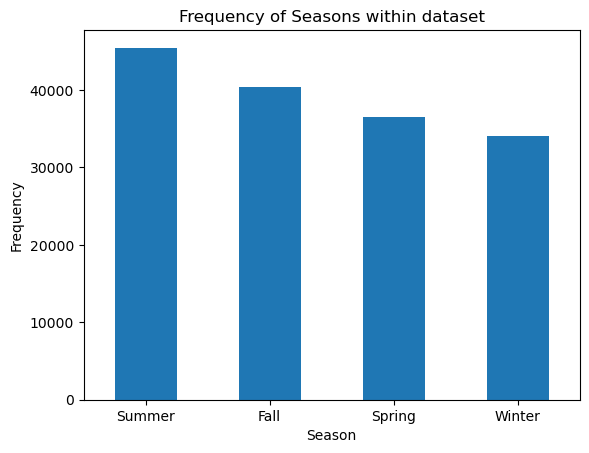

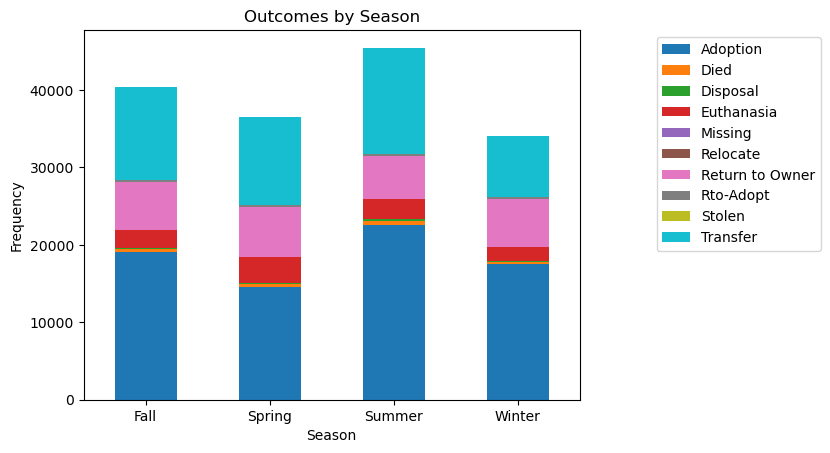

In [90]:
season_counts = data['Season'].value_counts()
season_counts.plot(kind='bar')
plt.title('Frequency of Seasons within dataset')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.show()

outcome_by_season = pd.crosstab(data['Season'], data['Outcome Type'])
outcome_by_season.plot(kind='bar', stacked=True)
plt.title('Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

plt.show()

The distribution of pets outcomes is relatively even between each season.

Now, let's explore the animal type and breeds features. 

In [91]:
print("\nAnimal Type distribution")
outcome_counts = data['Animal Type'].value_counts()
print(outcome_counts)


Animal Type distribution
Animal Type
Dog          86520
Cat          60833
Other         8215
Bird           773
Livestock       27
Name: count, dtype: int64


The majority of data is cat and dog records. However, there are also birds, livestock, and other animals in this dataset. We decided to remove the birds and livestock data records because they are a small minority of the data. We also removed the "other" animal type records category because it's difficult to categorize them in a broader model because we don't know what the type of animals they. They could have a dramatic influence on our models, but we wouldn't be able pinpoint the specific data causing the issues. Finally, we chose to stick with one animal type because the conditions/attributes of a particular species of animal that leads to their outcome can be very different when comparing species. Having multiple species in our models can taint our predictions as each species features could influence the outcome predictions in different ways. 

Now lets look at breeds.

In [92]:
print("\nAnimal Breed distribution")
outcome_counts = data['Breed'].value_counts()
print(outcome_counts)


Animal Breed distribution
Breed
Domestic Shorthair Mix             33588
Domestic Shorthair                 16779
Pit Bull Mix                        9621
Labrador Retriever Mix              8131
Chihuahua Shorthair Mix             6758
                                   ...  
Afghan Hound/Labrador Retriever        1
Chesa Bay Retr/Pit Bull                1
Pekingese/Toy Poodle                   1
Pomeranian/Cairn Terrier               1
Pointer/English Coonhound              1
Name: count, Length: 2881, dtype: int64


There are a vast number of unique breeds in this dataset (2881). We need a clearer way to categorize these breeds, so our models can interpret the data we pass into them well. Passing in individual breeds might be too specific for the model to generalize for outside / new instances of data. We need a way to condense this data.


The solution we decided to pursue is choosing the most frequently seen breeds in the dataset (we chose the top 100) and further categorize the specific breeds into sizes. We engineered a new column for species size and mapped each breed (out of the most 100 popular) into their respective size category. 

This is the website we used to bucket breeds into sizes: https://www.trainpetdog.com/dog-breed-size-chart/. Here we condense the animal type and breed columns

In [93]:
# only keep records that are Dogs
records_to_keep = ['Dog']
dog_data = data[data['Animal Type'].isin(records_to_keep)]

# only keep top 100 most frequent dog breeds in dataset
top_100_breeds = dog_data['Breed'].value_counts().head(100).index
breeds_data = dog_data[dog_data['Breed'].isin(top_100_breeds)]
breeds_data = breeds_data.copy()

breed_to_category = {
    'Pit Bull Mix': 'Medium/Large Breeds',
    'Labrador Retriever Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair Mix': 'Small Breeds',
    'German Shepherd Mix': 'Medium/Large Breeds',
    'Pit Bull': 'Medium/Large Breeds',
    'Australian Cattle Dog Mix': 'Medium/Large Breeds',
    'Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever': 'Medium/Large Breeds',
    'German Shepherd': 'Medium/Large Breeds',
    'Dachshund Mix': 'Medium/Small Breeds', 
    'Boxer Mix': 'Medium/Large Breeds',
    'Border Collie Mix': 'Medium/Large Breeds',
    'Miniature Poodle Mix': 'Small Breeds',
    'Siberian Husky Mix': 'Medium Breeds',
    'Australian Shepherd Mix': 'Medium/Large Breeds',
    'Catahoula Mix': 'Medium/Large Breeds',
    'Staffordshire Mix': 'Medium/Large Breeds',
    'Siberian Husky': 'Medium Breeds',
    'Rat Terrier Mix': 'Small Breeds',
    'Great Pyrenees Mix': 'Large Breeds',
    'Yorkshire Terrier Mix': 'Small Breeds',
    'Beagle Mix': 'Medium/Large Breeds',
    'Miniature Schnauzer Mix': 'Medium/Small Breeds',
    'Jack Russell Terrier Mix': 'Medium/Small Breeds',
    'Pointer Mix': 'Large Breeds',
    'Cairn Terrier Mix' : 'Small Breeds',
    'American Bulldog Mix': 'Medium/Large Breeds',                      
    'Chihuahua Longhair Mix': 'Small Breeds',   
    'Anatol Shepherd Mix': 'Medium/Large Breeds',
    'Rottweiler Mix': 'Medium/Large Breeds',
    'Australian Cattle Dog': 'Medium Breeds',
    'Black Mouth Cur Mix': 'Medium/Large Breeds',
    'Plott Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Pit Bull': 'Medium/Large Breeds',
    'Australian Kelpie Mix': 'Medium Breeds',
    'Shih Tzu Mix': 'Small Breeds',
    'Chihuahua Shorthair/Dachshund': 'Small Breeds',
    'Great Pyrenees': 'Large Breeds',
    'American Pit Bull Terrier Mix': 'Medium/Large Breeds',
    'German Shepherd/Labrador Retriever': 'Large Breeds',
    'Dachshund/Chihuahua Shorthair': 'Small Breeds',
    'Labrador Retriever/German Shepherd': 'Large Breeds',
    'American Staffordshire Terrier Mix': 'Medium/Large Breeds',
    'Rottweiler': 'Large Breeds',
    'Boxer': 'Medium/Large Breeds',
    'Shih Tzu': 'Small Breeds',
    'Pit Bull/Labrador Retriever': 'Medium/Large Breeds',
    'Dachshund': 'Small Breeds',
    'Golden Retriever Mix': 'Large Breeds',
    'Maltese Mix': 'Small Breeds',
    'Border Terrier Mix': 'Small Breeds',
    'Miniature Pinscher Mix': 'Small Breeds',
    'Yorkshire Terrier': 'Small Breeds',
    'Blue Lacy Mix': 'Medium/Large Breeds',
    'Doberman Pinsch Mix': 'Medium/Large Breeds',
    'Miniature Poodle': 'Small Breeds',
    'Chow Chow Mix': 'Medium/Large Breeds',
    'American Pit Bull Terrier': 'Medium/Large Breeds',
    'Cairn Terrier': 'Small Breeds',
    'Border Collie': 'Medium/Large Breeds',
    'Queensland Heeler Mix': 'Medium Breeds',
    'Doberman Pinsch': 'Medium/Large Breeds',
    'Basset Hound Mix': 'Medium/Large Breeds',
    'Labrador Retriever/Border Collie': 'Large Breeds',
    'Alaskan Husky Mix': 'Medium/Large Breeds',
    'Pug Mix': 'Small Breeds',
    'Beagle': 'Small Breeds',
    'Pomeranian Mix': 'Small Breeds',
    'Mastiff Mix': 'Large Breeds',
    'Cocker Spaniel Mix': 'Small Breeds',
    'Cardigan Welsh Corgi Mix': 'Medium Breeds',
    'Miniature Schnauzer': 'Small Breeds',
    'Lhasa Apso Mix': 'Small Breeds',
    'Chinese Sharpei Mix': 'Medium/Large Breeds',
    'Australian Shepherd': 'Medium/Large Breeds',
    'Labrador Retriever/Australian Cattle Dog': 'Medium/Large Breeds',
    'Black/Tan Hound Mix': 'Medium/Large Breeds',
    'Pug': 'Small Breeds',
    'Chihuahua Longhair': 'Small Breeds',
    'Great Dane Mix': 'Large Breeds',
    'Boston Terrier Mix': 'Small Breeds',
    'Border Collie/Labrador Retriever': 'Large Breeds',
    'Labrador Retriever/Great Pyrenees' : 'Large Breeds',
    'Dachshund Wirehair Mix' : 'Small Breeds',
    'Dachshund Longhair Mix' : 'Small Breeds',
    'Alaskan Husky' : 'Medium/Large Breeds',
    'Flat Coat Retriever Mix' : 'Large Breeds',
    'Manchester Terrier Mix' : 'Small Breeds',
    'Toy Poodle Mix' : 'Small Breeds',
    'American Bulldog' : 'Medium/Large Breeds',
    'Rat Terrier' : 'Small Breeds',
    'Collie Smooth Mix' : 'Medium/Large Breeds',
    'Maltese' : 'Small Breeds',
    'Anatol Shepherd' : 'Medium/Large Breeds',
    'Staffordshire' : 'Medium/Large Breeds',
    'Belgian Malinois Mix' : 'Medium/Large Breeds',
    'Pit Bull/Boxer' : 'Medium/Large Breeds',
    'Norfolk Terrier Mix' : 'Small Breeds',
    'Australian Cattle Dog/Labrador Retriever' : 'Medium/Large Breeds',
    'Rhod Ridgeback Mix' : 'Large Breeds'         
}
print()
print("Distribution based on size of breed:")

categories = [breed_to_category.get(breed) for breed in breeds_data['Breed']]

category_counts = Counter(categories)

# make sure there is still sufficent data for each size of the animal
for category, count in category_counts.items():
    print(f'{category}: {count}')

# to do add a size category with the breed to wsize mapping
breeds_data.loc[:, 'Size'] = breeds_data['Breed'].map(breed_to_category)
dog_data = breeds_data


# drop breed and animal type
dog_data.drop(columns=['Breed', 'Animal Type'], inplace=True)
# make sure there is a new Size column that reflects the size of the breed for that animal
dog_data.head()


Distribution based on size of breed:
Small Breeds: 17144
Medium/Large Breeds: 41782
Large Breeds: 3910
Medium Breeds: 2854
Medium/Small Breeds: 2448


,Outcome Type,Sex upon Outcome,Age upon Outcome,Color,Season,Size
1,Adoption,Neutered Male,1 year,Brown/White,Summer,Small Breeds
5,Adoption,Spayed Female,7 years,Brown,Fall,Small Breeds
13,Return to Owner,Intact Female,2 years,Blue/White,Summer,Medium/Large Breeds
14,Transfer,Intact Female,2 years,Black/White,Fall,Small Breeds
27,Adoption,Neutered Male,9 years,Multicolor,Summer,Small Breeds


Let's look at the new distribution of data for the animal breeds sizes.

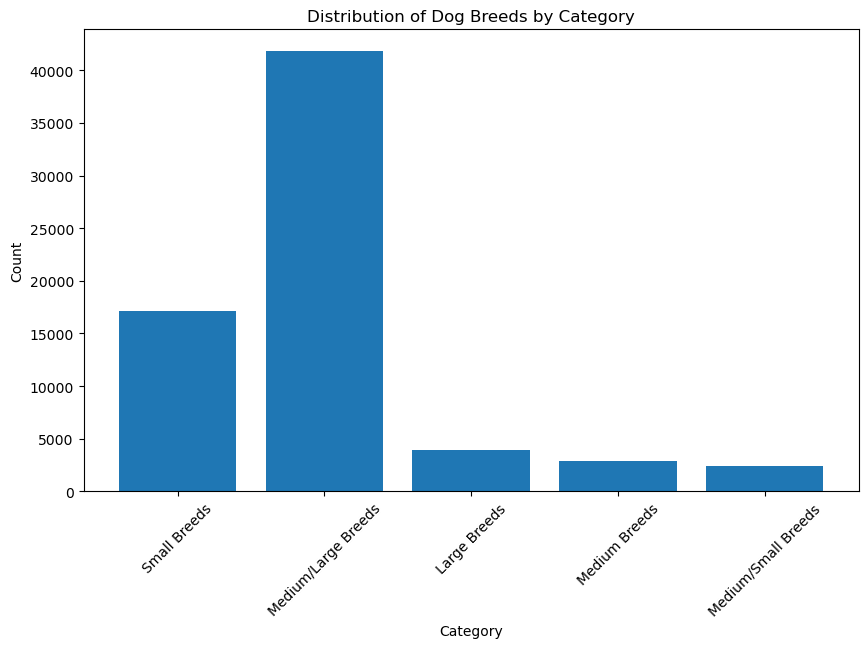

In [94]:
category_labels = [label for label, value in category_counts.items() if label is not None]
category_values = [value for label, value in category_counts.items() if label is not None]


plt.figure(figsize=(10, 6))
plt.bar(category_labels, category_values)
plt.title('Distribution of Dog Breeds by Category')
plt.xlabel('Category')
plt.ylabel('Count')

plt.xticks(rotation=45)

plt.show()

The distribution of sizes varies a lot. However, the same is likely true in real life as a various dogs of a variety of sizes exist. This distribution reflects the frequency of sizes seen in the shelter. 

It's interesting to note that a majority of our dogs are Medium/Large Breeds. There are also many small breed dogs.

Let's clean up our last few columns. We'll start with dog sex and sex subtype upon outcome.

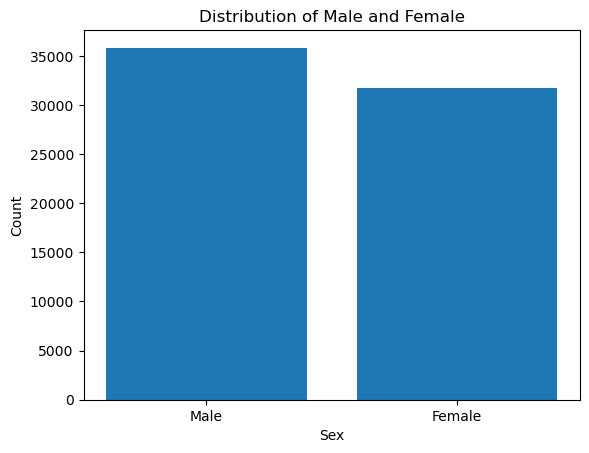

Number of Males: 35835
Number of Females: 31738


In [95]:
sex_upon_outcome = dog_data["Sex upon Outcome"]

male = 0
female = 0

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Male" in outcome:
            male += 1
        elif "Female" in outcome:
            female += 1

        
categories = ["Male", "Female"]
counts = [male, female]

plt.bar(categories, counts)
plt.title("Distribution of Male and Female")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

print(f"Number of Males: {male}")
print(f"Number of Females: {female}")

Sex upon Outcome
Neutered Male    27445
Spayed Female    24152
Intact Male       8390
Intact Female     7586
Unknown            565
Name: count, dtype: int64


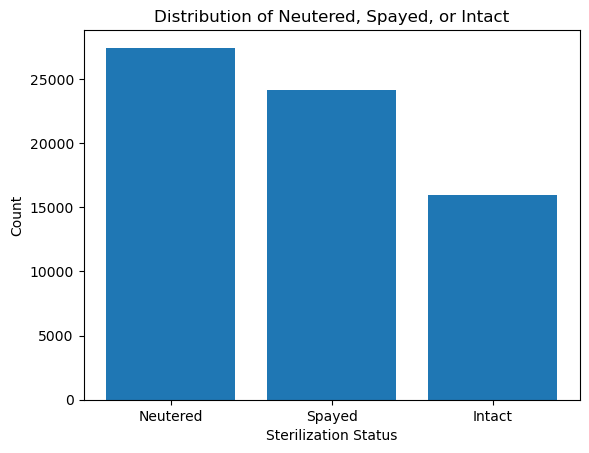

Number of Neutered: 27445
Number of Spayed: 24152
Number of Intact: 15976


In [96]:
neutered = 0
spayed = 0
intact = 0

sex_counts = dog_data["Sex upon Outcome"].value_counts()
print(sex_counts)

for outcome in sex_upon_outcome:
    if pd.notna(outcome):
        if "Neutered" in outcome:
            neutered += 1
        elif "Spayed" in outcome:
            spayed += 1
        elif "Intact" in outcome: 
            intact += 1
        
categories = ["Neutered", "Spayed", "Intact"]
counts = [neutered, spayed, intact]

plt.bar(categories, counts)
plt.title("Distribution of Neutered, Spayed, or Intact")
plt.xlabel("Sterilization Status")
plt.ylabel("Count")
plt.show()

print(f"Number of Neutered: {neutered}")
print(f"Number of Spayed: {spayed}")
print(f"Number of Intact: {intact}")


There isn't anything unusual about this feature, so we can keep it as is. 

Finally, we will look at the age column.

In [97]:
print("\nAnimal Age distribution")
outcome_counts = dog_data['Age upon Outcome'].value_counts()
print(outcome_counts)


Animal Age distribution
Age upon Outcome
2 years      13099
1 year       12532
2 months      6050
3 years       5409
4 years       3173
5 years       2938
1 month       2217
6 years       1934
4 months      1753
3 months      1737
5 months      1672
7 years       1662
8 years       1618
6 months      1482
8 months      1315
10 months     1294
10 years      1237
7 months       971
9 years        906
9 months       876
12 years       571
11 months      569
11 years       499
13 years       361
4 weeks        269
14 years       260
2 weeks        252
1 weeks        247
3 weeks        232
15 years       201
1 week         123
2 days         119
1 day          110
16 years       102
3 days          56
0 years         51
6 days          47
17 years        45
4 days          39
5 days          37
5 weeks         30
18 years        21
19 years        10
-1 years         5
20 years         4
-2 years         1
24 years         1
-3 years         1
Name: count, dtype: int64


The data in the age column is pretty inconsistent in the measure of time (some dogs are categorized with years while others months). Plus, there are negative ages we also must clean. Let's convert all the ages to years and also remove the negative age values.

Mean Age (in months): 30.50
Median Age (in months): 12.00
Mode Age (in months): 24


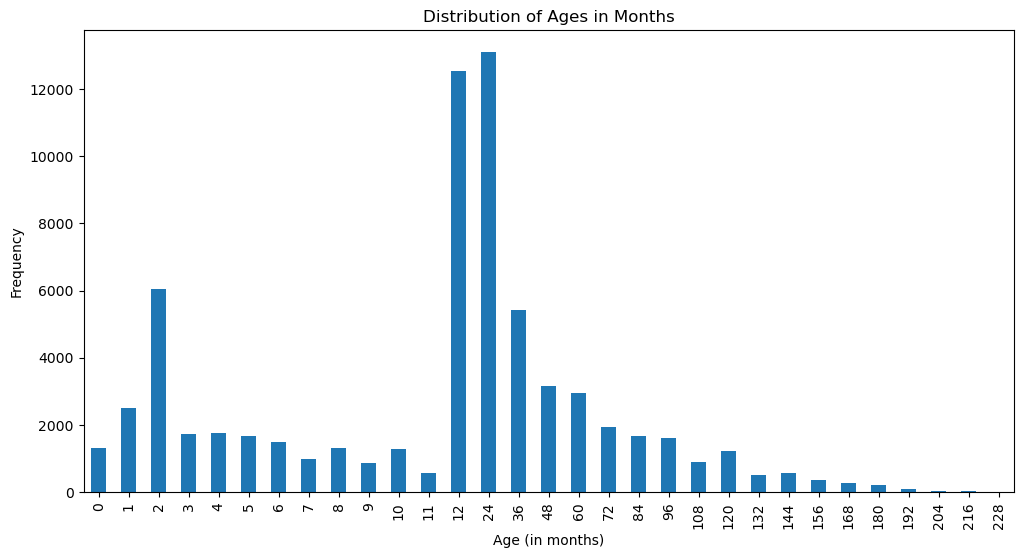

In [98]:
def convert_to_months(age_str):
    # Split the age string into value and unit
    value, unit = age_str.split()
    value = int(value)
    
    if 'year' in unit or 'years' in unit:
        return value * 12
    elif 'month' in unit or 'months' in unit:
        return value
    elif 'week' in unit or 'weeks' in unit:
        return value // 4  # Approximate conversion: 1 month = 4 weeks
    elif 'day' in unit or 'days' in unit:
        return value // 30 # Approximate conversion: 1 month = 30 days
    else:
        return 0  # default case

age_data = dog_data['Age upon Outcome']
df = pd.DataFrame(age_data)
df['Age upon Outcome'] = df['Age upon Outcome'].fillna('0 days')  #  fills NaN with '0 days'
# Apply the conversion function to the column
df['Age upon Outcome'] = df['Age upon Outcome'].apply(convert_to_months)
# print(df.head())

mean_age = df['Age upon Outcome'].mean()
median_age = df['Age upon Outcome'].median()
mode_age = df['Age upon Outcome'].mode()
age_df = df

print(f"Mean Age (in months): {mean_age:.2f}")
print(f"Median Age (in months): {median_age:.2f}")
print(f"Mode Age (in months): {mode_age.iloc[0]}")  

age_counts = df.loc[(df['Age upon Outcome'] >= 0) & (df['Age upon Outcome'] <= 228), 'Age upon Outcome'].value_counts().sort_index()
age_counts.plot(kind='bar', figsize=(12,6))
plt.title('Distribution of Ages in Months')
plt.xlabel('Age (in months)')
plt.ylabel('Frequency')
plt.show()

Here is the distribution of age data. Although ages of dogs at the animal shelter varies across the distribution, our data is all generalized into months and we no longer have negative values. 

In [99]:
df['Age upon Outcome'] = df[df['Age upon Outcome'] >= 0]
df['Age upon Outcome'].describe()

count    68131.000000
mean        30.501930
std         35.752807
min          0.000000
25%          7.000000
50%         12.000000
75%         36.000000
max        288.000000
Name: Age upon Outcome, dtype: float64

In [100]:
dog_data = dog_data.drop(columns=['Age upon Outcome'])
dog_data = pd.concat([dog_data, df.iloc[:, 0]], axis=1)
dog_data = dog_data[dog_data['Age upon Outcome'] >= 0]
dog_data.head()

,Outcome Type,Sex upon Outcome,Color,Season,Size,Age upon Outcome
1,Adoption,Neutered Male,Brown/White,Summer,Small Breeds,12.0
5,Adoption,Spayed Female,Brown,Fall,Small Breeds,84.0
13,Return to Owner,Intact Female,Blue/White,Summer,Medium/Large Breeds,24.0
14,Transfer,Intact Female,Black/White,Fall,Small Breeds,24.0
27,Adoption,Neutered Male,Multicolor,Summer,Small Breeds,108.0


## Part 1C. Feature Engineering: Encoding <a id='Part-3-Feature-Engineering-for-Models'></a>
We want to numerically represent our data for ease and accuracy of modeling prior to inserting them into our models. They also need to be represented numerically to allow for scaling in the models that need it. 

In [101]:
dog_data.head()

,Outcome Type,Sex upon Outcome,Color,Season,Size,Age upon Outcome
1,Adoption,Neutered Male,Brown/White,Summer,Small Breeds,12.0
5,Adoption,Spayed Female,Brown,Fall,Small Breeds,84.0
13,Return to Owner,Intact Female,Blue/White,Summer,Medium/Large Breeds,24.0
14,Transfer,Intact Female,Black/White,Fall,Small Breeds,24.0
27,Adoption,Neutered Male,Multicolor,Summer,Small Breeds,108.0


#### Encode Sex and Color: 
This code performs one-hot encoding on the categorical columns 'Sex upon Outcome' and 'Color' in the 'dog_data' DataFrame, creating binary columns for each category. The encoded columns are then concatenated with the original DataFrame, and the original categorical columns are dropped, resulting in a DataFrame with expanded feature representations for 'Sex upon Outcome' and 'Color'.

In [102]:
encoded_sex = pd.get_dummies(dog_data['Sex upon Outcome'], prefix='Sex upon Outcome').astype(int)
encoded_colors = pd.get_dummies(dog_data['Color'], prefix='Color').astype(int)
dog_data = pd.concat([dog_data, encoded_sex, encoded_colors], axis=1)
dog_data = dog_data.drop(columns=['Color', 'Sex upon Outcome'])
dog_data.head()

,Outcome Type,Season,Size,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,...,Color_Brown,Color_Brown Brindle/White,Color_Brown/White,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White
1,Adoption,Summer,Small Breeds,12.0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,Adoption,Fall,Small Breeds,84.0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
13,Return to Owner,Summer,Medium/Large Breeds,24.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,Transfer,Fall,Small Breeds,24.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,Adoption,Summer,Small Breeds,108.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


#### Encode Size: 
This code snippet encodes the 'Size' column in the 'dog_data' DataFrame ordinally based on predefined size categories. It creates a new column named 'Breed size' where each dog's size is represented by an ordinal encoding, and subsequently, the original 'Size' column is dropped from the DataFrame. 

In [103]:
# encode breeds ordinally
sizes = ['Small Breeds', 'Medium/Small Breeds', 'Medium/Large Breeds', 'Large Breeds']

size_encode_mapping = {
    'Small Breeds': 1,
    'Medium/Small Breeds': 2,
    'Medium Breeds': 3,
    'Medium/Large Breeds': 4,
    'Large Breeds': 5
}

dog_data['Breed size'] = dog_data['Size'].map(size_encode_mapping)
dog_data = dog_data.drop(columns=['Size'])


dog_data.head()

,Outcome Type,Season,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,Color_Black/Brown,...,Color_Brown Brindle/White,Color_Brown/White,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White,Breed size
1,Adoption,Summer,12.0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5,Adoption,Fall,84.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13,Return to Owner,Summer,24.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
14,Transfer,Fall,24.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
27,Adoption,Summer,108.0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


#### Encode Season: 
This code snippet encodes the 'Season' column in the 'dog_data' DataFrame cyclically using sine and cosine functions. It creates two new columns, 'Season_cos' and 'Season_sin', which represent the cyclic encoding of seasons. The original 'Season' column and an intermediate numeric encoding column are then dropped from the DataFrame, resulting in a dataset where seasons are represented as cyclical features through trigonometric functions.

In [104]:
## encode seasons cyclically with sine and cosine functions
season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Fall': 3}
dog_data['Season_numeric_encode'] = dog_data['Season'].map(season_mapping)
dog_data['Season_cos'] = np.cos(2 * np.pi * dog_data['Season_numeric_encode'] / 4)
dog_data['Season_sin'] = np.sin(2 * np.pi * dog_data['Season_numeric_encode'] / 4)
dog_data = dog_data.drop(columns=['Season', 'Season_numeric_encode'])
dog_data.head()

,Outcome Type,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,Color_Black/Brown,Color_Black/Tan,...,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White,Breed size,Season_cos,Season_sin
1,Adoption,12.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.000000e+00,1.224647e-16
5,Adoption,84.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
13,Return to Owner,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,-1.000000e+00,1.224647e-16
14,Transfer,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
27,Adoption,108.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-1.000000e+00,1.224647e-16


## Part 2. Data Modeling <a id='Part-4-Data-Modeling'></a>


We use the following different machine learning models for the dataset:

1. Naive Bayes
2. Decision Tree
3. KNN
4. SVM
5. Ensembling (Random Forest) + (with SMOTE)
6. Decision Tree (with SMOTE)

Since our data has been cleaned and engineered, let's start by setting the label and feature variables

In [105]:
#set label col to Outcome Type
label = dog_data['Outcome Type']
label = label.values.ravel()
features = dog_data.drop(['Outcome Type'],axis=1)


#verify we have correct columns
dog_data.head()

,Outcome Type,Age upon Outcome,Sex upon Outcome_Intact Female,Sex upon Outcome_Intact Male,Sex upon Outcome_Neutered Male,Sex upon Outcome_Spayed Female,Sex upon Outcome_Unknown,Color_Black,Color_Black/Brown,Color_Black/Tan,...,Color_Calico,Color_Multicolor,Color_Red,Color_Red/White,Color_Tan,Color_Tan/White,Color_White,Breed size,Season_cos,Season_sin
1,Adoption,12.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.000000e+00,1.224647e-16
5,Adoption,84.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
13,Return to Owner,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,-1.000000e+00,1.224647e-16
14,Transfer,24.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-1.836970e-16,-1.000000e+00
27,Adoption,108.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,-1.000000e+00,1.224647e-16


Now we'll import all the libraries we need for our models.

In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

import numpy as np
import warnings

### Model 1. Naive Bayes
First, we are using Naive Bayes on our data. We started with this because it is a fast and simple algorithm, scalable (performs well on large datasets such as this one), and avoids issues with curse of dimensionality. Let's create a Multinomial Naive Bayes classifier (since it supports categorical target variables) and perform a 10-fold cross validation on the classifier. 

Here we see the accuracy

In [107]:
warnings.filterwarnings("ignore")

# verify shape is correct for NB model
print(dog_data.shape)
print(label.shape)

# normalize and scale features
features = pd.DataFrame(features)
label = pd.DataFrame(label)
le = LabelEncoder()
features = features.apply(le.fit_transform)
label = label.apply(le.fit_transform)

# scale data
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# finally model data and check accuracy
mnb = MultinomialNB()
mnb_predict = cross_val_predict(mnb, features, label, cv=10)
accuracy = accuracy_score(label, mnb_predict)
print('Model accuracy: ', accuracy)


warnings.resetwarnings()

(68131, 26)
(68131,)
Model accuracy:  0.6026038073710939


Now we'll visually display our results for the Naive Bayes Model by using a confusion matrix map.

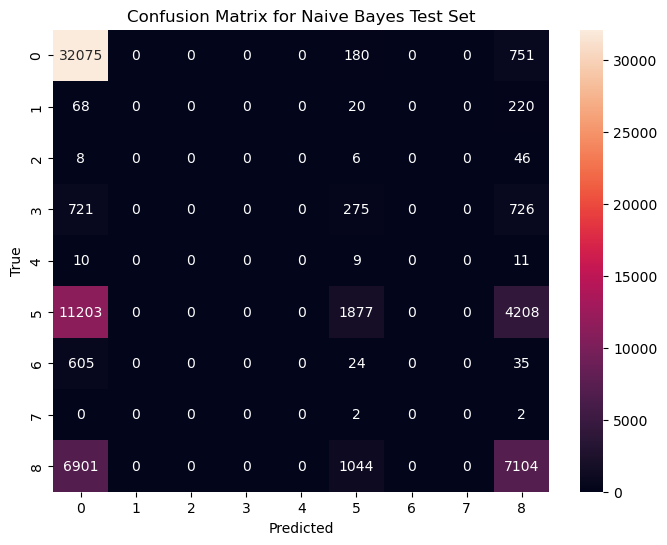

In [108]:
cm = confusion_matrix(label, mnb_predict)

unique_labels = np.unique(label)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_labels , yticklabels=unique_labels)
plt.title('Confusion Matrix for Naive Bayes Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The model accuracy for Naive Bayes is 60.3%. This is an okay start, but we want to improve this accuracy. 

A potential reason for why this accuracy is low could be the fact that the independence assumption may not always hold true in Naive Bayes. Specifically, in the case of our dataset, the size and age features may correlate. Thus, we will now try using decision tree model. 

### Model 2. Decision Tree

Next, we will create a Decision Tree. We chose this model next because it is computationally inexpensive and easy to interpret (similar to naive bayes). However, unlike naive bayes, it is robust in presence of outliers, which will hopefully improve our accuracy rate. 

We implemented hyperparameter optimization for a Decision Tree classifier using a grid search strategy to find the identify the most effective combination of hyperparameters—specifically, the maximum depth of the Decision Tree (`max_depth`) and the number of splits in the StratifiedKFold cross-validator (`n_splits`). Further, a cross-validation was implemented to ensure the best split of the dataset.

The script tracks the best hyperparameter values by comparing mean accuracies. 

In [109]:
warnings.filterwarnings("ignore")

# max_depth and n_splits we want to try
max_depth_values = [5, 10, 15, 20]
n_splits_values = [10, 20, 30, 40]

best_mean_accuracy = 0
best_max_depth = None
best_n_splits = None
best_dt_pred = 0

# iterate over max_depth and n_splits values
for max_depth in max_depth_values:
    for n_splits in n_splits_values:
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=2)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # perform cross-validation
        dt_pred = cross_val_predict(dt_model, features, label, cv=cv)
        mean_accuracy = accuracy_score(label, dt_pred)

        # update the best parameters if the current combination is better
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_max_depth = max_depth
            best_n_splits = n_splits
            best_dt_pred = dt_pred
            
# print the best hyperparameters and mean accuracy
print("Best Max Depth:", best_max_depth)
print("Best N_splits:", best_n_splits)
print("Best Mean Accuracy:", best_mean_accuracy)

warnings.resetwarnings()


Best Max Depth: 5
Best N_splits: 40
Best Mean Accuracy: 0.6222864775212459


Now we'll visually display our results for the Decision Tree Model by using a confusion matrix map.

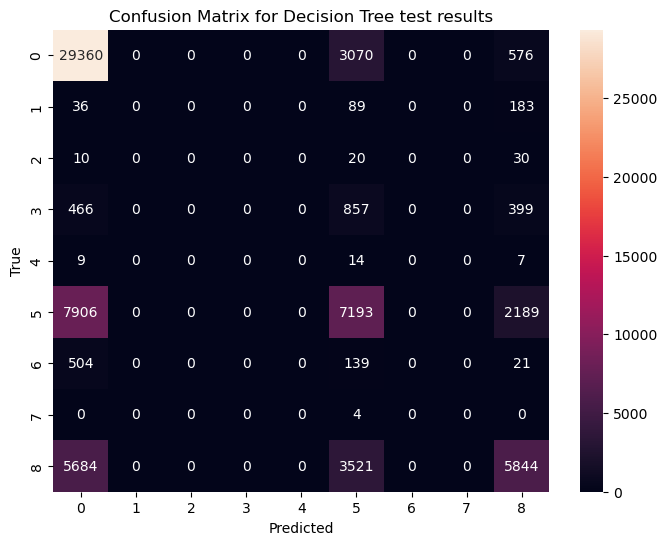

In [111]:
# confusion matrix for test set predictions
unique_labels = np.unique(label)
conf_matrix = confusion_matrix(label, best_dt_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree test results')
plt.show()

The average accuracy for the model is 62.2%. The use of the Decision tree model slightly improved our accuracy, so we're headed in the right direction.

Unfortunately decision trees are succeptible to data fragmentation (overfitting) and are sensitive to class imbalance. Thus we attempted to improve accuracy by trying out KNN, which can address class imbalances. 

### Model 3: K-Nearest Neighbor

The K-nearest neighbor model is an algorithm that's simple to understand and implement. It's simplicity and high accuracy potential is why we decided to use it to model our dataset. However, there are various additional considerations we must take into account when using KNN. 

For example, the majority of our outcome instances are adoption, return to owner, and transfer. These outcomes are only three out of nine potential outcomes but make up about 95% of the outcome types in our data. We need to institute a measure to combat against this class imbalance. The idea behind weighted voting is to give more importance to the minority class so that the model pays more attention to correctly classifying instances from that class. So we will use it as a hyperparameter (through grid search) for our model to check if it will resolve our class imbalance issue and improve our accuracy. 

We will also hypertune our parameter K to find a K value that fits our data well and can generalize to new data points too, avoiding overfitting or underfitting. 

Here we're training KNN Model. Grid search will allow us to optimize for our paramaters. We also want to scale our data before training the model since the KNN's algorithm is based on distance and we want to make sure each feature's distances are on the same scale. 



In [112]:
warnings.filterwarnings("ignore")

# scale data
scaler = StandardScaler()
features_scaled =  scaler.fit_transform(features)
features_scaled = np.ascontiguousarray(features_scaled)


#initialize parameter grid to find best parameters
param_grid = {
    'n_neighbors': range(3, 25),
    'weights': ['uniform', 'distance']
}

#create knn classifier 
KNN_classifier = KNeighborsClassifier()

# search for best parameters
grid_search = GridSearchCV(KNN_classifier, param_grid, cv=4, scoring='accuracy')
grid_search.fit(features, label)
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN model:", best_params)

warnings.resetwarnings()

Best Hyperparameters for KNN model: {'n_neighbors': 24, 'weights': 'uniform'}


Calculate the accuracy for the model

In [113]:
warnings.filterwarnings("ignore")

# calculate accuracy using best parameters
best_model = grid_search.best_estimator_
y_pred = cross_val_predict(best_model, features, label, cv=5) 
accuracy = accuracy_score(label, y_pred)
print("Model accuracy:", accuracy)

# get classfification report
report = classification_report(label, y_pred, zero_division=1)
print("Classification Report:\n", report)

warnings.resetwarnings()


Model accuracy: 0.6130542631107719
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.89      0.76     33006
           1       1.00      0.00      0.00       308
           2       1.00      0.00      0.00        60
           3       1.00      0.00      0.00      1722
           4       1.00      0.00      0.00        30
           5       0.47      0.37      0.41     17288
           6       1.00      0.00      0.00       664
           7       1.00      0.00      0.00         4
           8       0.60      0.40      0.48     15049

    accuracy                           0.61     68131
   macro avg       0.86      0.18      0.18     68131
weighted avg       0.61      0.61      0.58     68131



Now we'll visually display our results for the KNN Model by using a confusion matrix map.

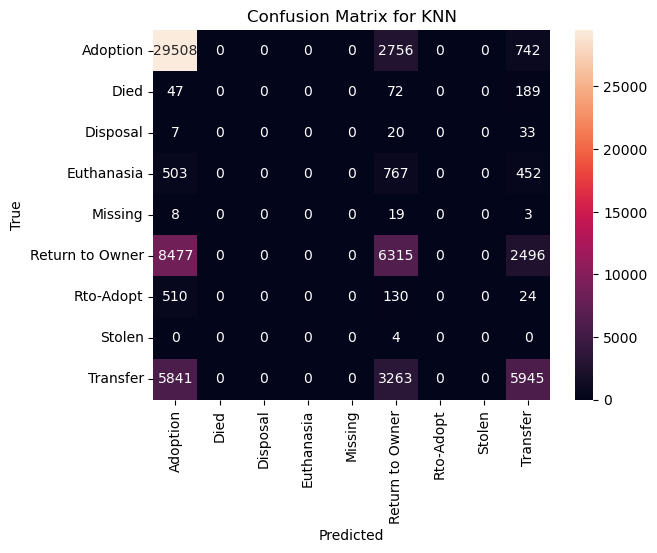

In [114]:
class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

The accuracy of the KNN model is 61.3%. Interestingly, the best hyperparameter for voting is uniform voting, meaning that weighted voted was unable to successfully resolve our class imbalance. Potentially, the curse of dimensionality is what's limiting our accuracy, so we'll next try to SVM model which is resistant to it. 

### Model 4: SVM

We decided to go with using an SVM to model our dataset. It isn't succeptible to curse of dimensionality (like KNN is), and there are known algorithms to arrive at optimal solution (unlike decision trees which use a greedy approach), so it could help improve accuracy

For this model, use logistic regression and randomized search to improve computational speeds.

In [115]:
warnings.filterwarnings("ignore")

param_grid = {
    'C': [0.1, 10],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'max_iter': [500], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
}

simple_model = LogisticRegression()
rand_search = RandomizedSearchCV(simple_model, param_grid, cv=4, scoring='accuracy', verbose=1, n_jobs=-1, n_iter=10)
rand_search.fit(features, label)

# evaluate
y_pred = rand_search.predict(features)
accuracy = accuracy_score(label, y_pred)
print("Accuracy of Logistic Regression model with Randomized Search: ", accuracy)
print(classification_report(label, y_pred))
warnings.resetwarnings()

Fitting 4 folds for each of 10 candidates, totalling 40 fits


/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/shrutikotha/anaconda3/l

/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shrutikotha/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/shrutikotha/anaconda3/l

Accuracy of Logistic Regression model with Randomized Search:  0.6229910026272916
              precision    recall  f1-score   support

           0       0.66      0.92      0.76     33006
           1       0.00      0.00      0.00       308
           2       0.00      0.00      0.00        60
           3       0.50      0.00      0.00      1722
           4       0.00      0.00      0.00        30
           5       0.50      0.34      0.41     17288
           6       0.00      0.00      0.00       664
           7       0.00      0.00      0.00         4
           8       0.61      0.42      0.50     15049

    accuracy                           0.62     68131
   macro avg       0.25      0.19      0.19     68131
weighted avg       0.59      0.62      0.58     68131



The accuracy of the SVM model is 62.3%.

SVMs are computationally expensive, so implementing logistic regression and randomized search instead of using kernel methods and grid search may yield better results but would take more computational effort than feasible by our personal computers. 

So far, we've tried many of the individual base classifiers. However, our accuracy results have been limited. We'll try combining base classifers in hopes to get a better accuracy through ensembling. 

### Model 5 Ensembling:
Let's try ensembling with random forests. We decided to go with this model because ensembling base classifiers usually performs better because it combines the predictions of multiple base classifiers. 

#### Random forests: 
Let's use a GridSearchCV with a 3-fold CV and try 15, 25, and 50 base classifiers of fully grown decision trees and see which performs best. Then wrap the GridSearchCV in a cross_val_predict with 5-fold CV and display the classification report.

In [116]:
warnings.filterwarnings("ignore")

rf = RandomForestClassifier()

parameter = {
    'n_estimators': [15, 25, 50]
}
grid = GridSearchCV(rf, parameter, cv=3)
pred = cross_val_predict(grid, features, label, cv=5)
print('Model accuracy: ', accuracy_score(label, pred))

print('\n Classification Report: \n', classification_report(label, pred))
warnings.resetwarnings()

Model accuracy:  0.5933569153542441

 Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.85      0.75     33006
           1       0.02      0.01      0.01       308
           2       0.07      0.03      0.05        60
           3       0.09      0.03      0.04      1722
           4       0.00      0.00      0.00        30
           5       0.46      0.38      0.41     17288
           6       0.04      0.01      0.01       664
           7       0.00      0.00      0.00         4
           8       0.53      0.38      0.45     15049

    accuracy                           0.59     68131
   macro avg       0.21      0.19      0.19     68131
weighted avg       0.56      0.59      0.57     68131



Now we'll visually display our results for the Decision Tree Model by using a confusion matrix map.

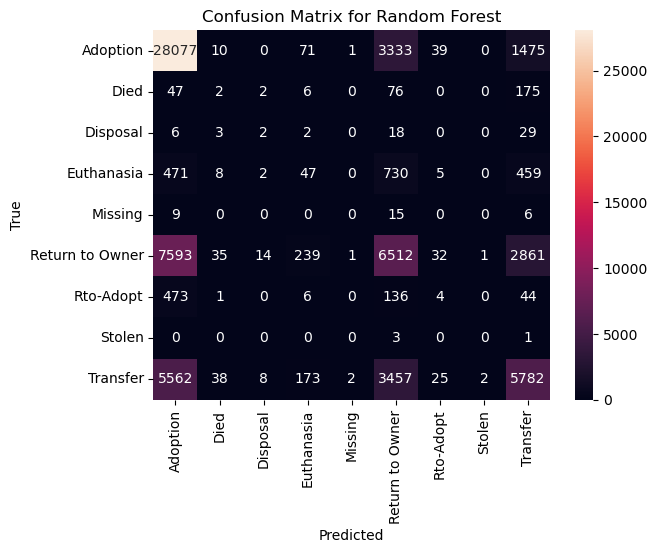

In [117]:
class_names = np.unique(dog_data['Outcome Type'])
cm = confusion_matrix(label, pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Using random forest gives a lower accuracy rate (59%) which is not what we expected since ensembling methods should improve accuracy. 

Since we've tried many models and also attempted ensembling, it's likely that the issue with low accuracy doesn't lie within our choice of models but rather our data / class imbalance that exists within our data.  Our confusion matrix exemplifies this as the three majority classes (adoption, return to owner, and transfer) are predicted at higher accuracy rates while the other classes aren't predicted as correctly. In our search to find ways to resolve class imbalance again, we came across the Synthetic Minority Over-sampling Technique. 

Next, we will attempt oversampling our minority classes using this tecnhique to see whether that can reduce the class imbalance bias and improve accuracy rates.

#### Random Forest (with oversampling)


We use SMOTE (Synthetic Minority Over-sampling Technique) for oversampling which synthesizes new data for the minority classes by creating a new data instance by randomly sampling one of its k-nearest neighbors and adding the new record between the original instance and its neighbor in the feature space. 

In [118]:
warnings.filterwarnings("ignore")

# separate features & labels
features_rf = dog_data.drop('Outcome Type', axis=1)
labels_rf = dog_data['Outcome Type']

# Oversample minority classes using SMOTE
print("Label distribution before oversampling ")
print(pd.Series(labels_rf).value_counts())

# used k_neighbors = 3 because k_neighbors needs to be a value lower than the frequency of our minority class which
# is at 4
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=3)
features_oversampled, labels_oversampled = smote.fit_resample(features_rf, labels_rf)
print("\nLabel distribution after oversampling ")
print(pd.Series(labels_oversampled).value_counts())

# repeat random forest with oversampled data
labels_oversampled = labels_oversampled.values.ravel()
rf = RandomForestClassifier()

# find optimal model
parameter = {
    'n_estimators': [15, 25, 50]
}
grid = GridSearchCV(rf, parameter, cv=3)
pred = cross_val_predict(grid, features_oversampled, labels_oversampled, cv=5)
print('Accuracy: ', accuracy_score(labels_oversampled, pred))

print('\nClassification Report training data : \n', classification_report(labels_oversampled, pred))

warnings.resetwarnings()


Label distribution before oversampling 
Outcome Type
Adoption           33006
Return to Owner    17288
Transfer           15049
Euthanasia          1722
Rto-Adopt            664
Died                 308
Disposal              60
Missing               30
Stolen                 4
Name: count, dtype: int64

Label distribution after oversampling 
Outcome Type
Adoption           33006
Return to Owner    33006
Transfer           33006
Rto-Adopt          33006
Euthanasia         33006
Died               33006
Disposal           33006
Missing            33006
Stolen             33006
Name: count, dtype: int64
Accuracy:  0.7805853481185239

Classification Report training data : 
                  precision    recall  f1-score   support

       Adoption       0.59      0.65      0.62     33006
           Died       0.87      0.91      0.89     33006
       Disposal       0.93      0.94      0.94     33006
     Euthanasia       0.75      0.71      0.73     33006
        Missing       0.93      0.9

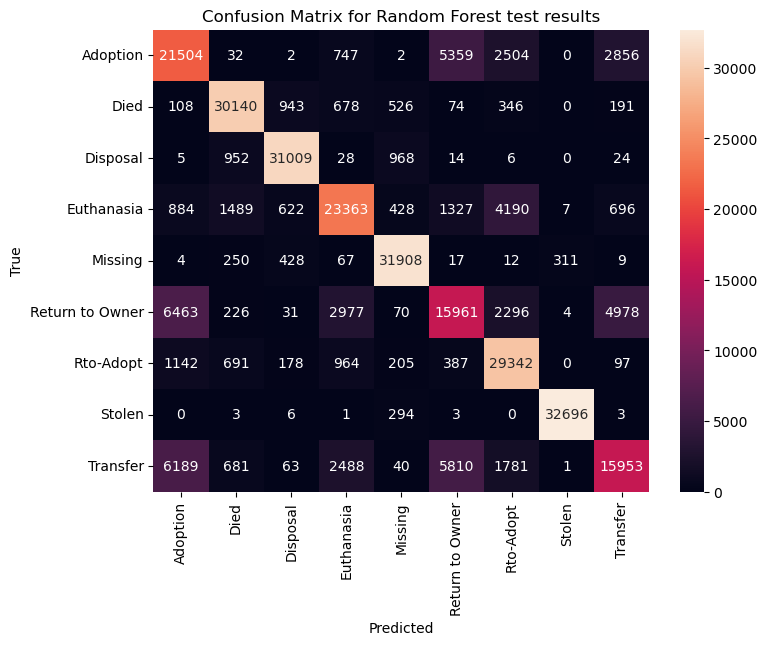

In [119]:
# confusion matrix for test set predictions
unique_labels = np.unique(labels_oversampled)
conf_matrix = confusion_matrix(labels_oversampled, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest test results')
plt.show()

Oversampling was able to drastically improve our accuracy rates as we now are at a 78% accuracy with random forest ensembling. However, while it did improve our accuracy, increasing the number of samples that each model trains on increases computation expenses. The tradeoff is that modeling becomes more time intensive as it takes much longer for each model to run.

### Model 6 Decision Tree with Oversampling:
As a final run, we'll try using our oversampled data with one of our strongest base classifier (decision tree model) to display an improvement accuracy.

In [120]:
warnings.filterwarnings("ignore")

# max_depth and n_splits we want to try
max_depth_values = [5, 10, 15, 20]
n_splits_values = [10, 20, 30, 40]

best_mean_accuracy = 0
best_max_depth = None
best_n_splits = None
best_dt_pred = 0

# iterate over max_depth and n_splits values
for max_depth in max_depth_values:
    for n_splits in n_splits_values:
        dt_model = DecisionTreeClassifier(random_state=42, max_depth=max_depth, min_samples_split=2)
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

        # perform cross-validation
        dt_pred = cross_val_predict(dt_model, features_oversampled, labels_oversampled, cv=cv)
        mean_accuracy = accuracy_score(labels_oversampled, dt_pred)

        # update the best parameters if the current combination is better
        if mean_accuracy > best_mean_accuracy:
            best_mean_accuracy = mean_accuracy
            best_max_depth = max_depth
            best_n_splits = n_splits
            best_dt_pred = dt_pred

# print the best hyperparameters and mean accuracy
print("Best Max Depth:", best_max_depth)
print("Best N_splits:", best_n_splits)
print("Best Mean Accuracy:", best_mean_accuracy)
warnings.resetwarnings()


Best Max Depth: 20
Best N_splits: 40
Best Mean Accuracy: 0.7686346590182257


In [121]:
report = classification_report(labels_oversampled, best_dt_pred)
print(report)

                 precision    recall  f1-score   support

       Adoption       0.58      0.65      0.61     33006
           Died       0.86      0.92      0.89     33006
       Disposal       0.92      0.94      0.93     33006
     Euthanasia       0.71      0.67      0.69     33006
        Missing       0.91      0.99      0.95     33006
Return to Owner       0.54      0.44      0.48     33006
      Rto-Adopt       0.68      0.88      0.77     33006
         Stolen       0.99      1.00      0.99     33006
       Transfer       0.66      0.43      0.52     33006

       accuracy                           0.77    297054
      macro avg       0.76      0.77      0.76    297054
   weighted avg       0.76      0.77      0.76    297054



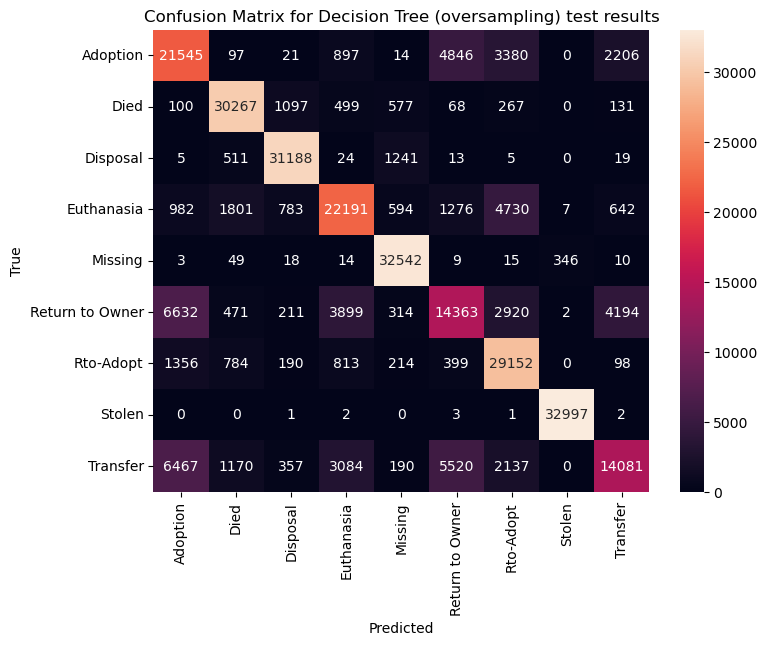

In [122]:
# confusion matrix for test set predictions
unique_labels = np.unique(labels_oversampled)
conf_matrix = confusion_matrix(labels_oversampled, best_dt_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree (oversampling) test results')
plt.show()

The model accuracy for the most optimal decision tree model is 76.8% . This is a good increase from our first attempt to use the decision tree model, demonstrating that SMOTE was successful in improving the accuracy of our model. 

## Outcome and Results <a id='Outcome'></a>

**Data Preprocessing and Feature Engineering:**
We started the project understanding our dataset and performing data preprocessing steps. A significant portion of the project timeline was devoted to **data cleaning and feature engineering**, recognizing their importance on the overall accuracy of the models. The emphasis on data cleaning involved handling missing values. Feature engineering efforts included refining color data representation, introducing a season column, and categorizing dog breeds by size. This time investment in data preparation was crucial for ensuring the reliability and accuracy of any of the predictive models we implemented.

**Modeling and Analysis:**
The project was successfully completed with an accuracy of at least 60% in determining the outcome type of dogs entering the animal center. Given the size of the dataset, we were fairly satisfied with the outcome. However, we realized we should improve the accuracy for the model to be useful for the Austin Animal Center. Various machine learning algorithms, including **Naive Bayes, K-Nearest Neighbors (KNN), Decision Tree, and Support Vector Machines (SVM)**, were employed to model our data and solve the classification problem.

**Addressing Class Imbalance:**
We noticed one potential factor contributing to the observed lower accuracy is the existence of class imbalance within the dataset. For instance, certain classes such as Adoption had a substantial number of records (73675 records), leading to accurate predictions, while underrepresented classes like Missing (84 records) faced challenges in accurate predictions. To mitigate this imbalance, we implemented techniques such as **Boosting and Synthetic Minority Over-sampling Technique (SMOTE)**.

**Model Exploration and Selection:**
The exploration of various machine learning models for predicting outcomes in the given dataset revealed interesting insights into their performances. We started with **Naive Bayes**, its simplicity and scalability proved advantageous for the large dataset, but the independence assumption limitations were evident, particularly when variables such as size and age correlated. The result was an accuracy of 60.3% for the model.

Next, we moved to **Decision Trees**, their computational efficiency and interpretability made them a reasonable choice. Hyperparameter optimization, specifically with a maximum depth of 5 and 40 splits, resulted in a 62.3% model accuracy. However, decision trees are susceptible to data fragmentation, leading to potential overfitting, so we decided to continue exploring other models.

Next, we explored **K-Nearest Neighbors (KNN)** which presented a simple yet effective approach. To address class imbalance, weighted voting was implemented. The grid search for optimal parameters revealed the best results with three neighbors and uniform weights, yielding a model accuracy of 61.3%.

Next, we looked into **Support Vector Machines (SVM)**, which showcased advantages such as resistance to the curse of dimensionality but came with computational expenses. Logistic regression and randomized search were employed due to their efficiency. While offering good accuracy (62.3%), SVM's computational demands remained a challenge.

We implemented ensemble methods, specifically with **Random Forests** being the base classifier, which displayed promise in aggregating predictions, but the class bias toward majority classes impacted overall accuracy. As mentioned before, to combat the class imbalance, we implemented SMOTE. Oversampling through SMOTE significantly improved Random Forest's accuracy to 78%, but it increased computational costs. Additionally, oversampling significantly improved precision and recall for all categories except adoption (which lowered quite a bit), as adoption was the dominant class prior to the oversampling. In the future, we would like to consider ways to improve the recall and precision for the original majority classes after oversampling.

The exploration with oversampling extended to **AdaBoost**, demonstrating varied precision and recall across different outcome types. Finally, **decision trees with oversampling** achieved a notable accuracy of 76.8%, showcasing the effectiveness of addressing class imbalances.

**Conclusion:**
Addressing class imbalances through techniques like oversampling proved crucial for enhancing model performance. The results underscore the trade-offs between model complexity, interpretability, and computational efficiency.

In conclusion, our project showcased the importance of adapting machine learning approaches to the characteristics of the dataset, especially when dealing with class imbalances. While each model exhibited strengths and limitations, the incorporation of oversampling techniques proved successful in enhancing overall accuracy. We enjoyed learning about new data cleaning and model methodology along the way. Additionally, we found it interesting to analyze the aspects that affect dog outcome. Future implementations may involve refining hyperparameters, exploring advanced ensemble methods, and optimizing computational efficiency to scale the model for larger datasets. Another interesting observation we researched was dogs with names ending in “y” sounds are more likely to be adopted. Given more time, we would like to analyze and prove that theory. We also hope to notify the animal shelter of this model, as a means of even slightly helping them predict dog outtake.